# **Task 3 -  Last Mile Delivery Analysis**

## **Summary**
Kanav's Diminos Pizza franchise operates 24/7 with online orders and a 30-minute delivery guarantee. An upcoming audit focuses on delivery time and customer satisfaction, critical for the franchise's success. Kanav faces challenges in delivery fleet capacity planning, essential for maintaining timely deliveries and sustaining business growth.

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# **Data Overview**

In [77]:
# Load your datasets (ensure you load them with the correct dtypes for optimization)
orders = pd.read_csv('orders.csv', dtype={'order_id': 'int32'})  # Example for order_id optimization
order_items = pd.read_csv('order_items.csv', dtype={'order_id': 'int32'})  # Same here
products = pd.read_csv('products.csv', dtype={'item_id': 'category', 'Price': 'float32'})  # Price as float32
deliveries = pd.read_csv('deliveries.csv', dtype={'order_id': 'int32'})

# Clean the 'items_ordered' to ensure it's a list of product ids
order_items["items_ordered"] = order_items["items_ordered"].apply(lambda x: eval(x) if isinstance(x, str) else x)

# Step 1: Flatten the 'items_ordered' so each item gets its own row
order_items_expanded = order_items.explode("items_ordered").reset_index(drop=True)

# Step 2: Merge the expanded order_items with the products dataset to get product details
order_items_with_products = order_items_expanded.merge(
    products[['item_id', 'category', 'Item', 'Size', 'Price']],  # Only load necessary columns
    left_on="items_ordered",  # Matching 'items_ordered' with 'item_id' in products
    right_on="item_id",       # Column in products dataset containing product IDs
    how="left"
)

# Step 3: Merge with orders to add order details
orders_with_items = orders.merge(
    order_items_with_products,
    on="order_id",
    how="left"
)

# Step 4: Merge with deliveries to add delivery details
final_data = orders_with_items.merge(
    deliveries[['order_id', 'time_stamp', 'status']],  # Only load necessary columns
    on="order_id",
    how="left"
)

# Step 5: Check the final merged data
print(final_data.head())

# Optionally, save the final data to a CSV for further analysis
final_data.to_csv('final_data_with_products.csv', index=False)

    order_id      order_placed_at items_ordered item_id category  \
0  321230114  2020-12-11 00:01:29         p_025   p_025  Non Veg   
1  321230114  2020-12-11 00:01:29         p_025   p_025  Non Veg   
2  321230114  2020-12-11 00:01:29         p_025   p_025  Non Veg   
3  321230114  2020-12-11 00:01:29         p_032   p_032  Non Veg   
4  321230114  2020-12-11 00:01:29         p_032   p_032  Non Veg   

                 Item     Size  Price                     time_stamp  \
0   Chicken Dominator  Regular  365.0  2020-12-11 00:01:29.000000000   
1   Chicken Dominator  Regular  365.0  2020-12-11 00:06:29.000000000   
2   Chicken Dominator  Regular  365.0  2020-12-11 00:19:13.299151076   
3  Indi Chicken Tikka   Medium  599.0  2020-12-11 00:01:29.000000000   
4  Indi Chicken Tikka   Medium  599.0  2020-12-11 00:06:29.000000000   

             status  
0           Pending  
1  Out For Delivery  
2         Delivered  
3           Pending  
4  Out For Delivery  


In [78]:
final_data

,order_id,order_placed_at,items_ordered,item_id,category,Item,Size,Price,time_stamp,status
0,321230114,2020-12-11 00:01:29,p_025,p_025,Non Veg,Chicken Dominator,Regular,365.0,2020-12-11 00:01:29.000000000,Pending
1,321230114,2020-12-11 00:01:29,p_025,p_025,Non Veg,Chicken Dominator,Regular,365.0,2020-12-11 00:06:29.000000000,Out For Delivery
2,321230114,2020-12-11 00:01:29,p_025,p_025,Non Veg,Chicken Dominator,Regular,365.0,2020-12-11 00:19:13.299151076,Delivered
3,321230114,2020-12-11 00:01:29,p_032,p_032,Non Veg,Indi Chicken Tikka,Medium,599.0,2020-12-11 00:01:29.000000000,Pending
4,321230114,2020-12-11 00:01:29,p_032,p_032,Non Veg,Indi Chicken Tikka,Medium,599.0,2020-12-11 00:06:29.000000000,Out For Delivery
...,...,...,...,...,...,...,...,...,...,...
3476674,321684449,2024-01-31 23:55:46,p_022,p_022,Non Veg,Non Veg Supreme,Regular,365.0,2024-02-01 00:00:46.000000000,Out For Delivery
3476675,321684449,2024-01-31 23:55:46,p_022,p_022,Non Veg,Non Veg Supreme,Regular,365.0,2024-02-01 00:14:56.997433391,Delivered
3476676,321684449,2024-01-31 23:55:46,p_037,p_037,Veg,Coke,Regular,71.0,2024-01-31 23:55:46.000000000,Pending
3476677,321684449,2024-01-31 23:55:46,p_037,p_037,Veg,Coke,Regular,71.0,2024-02-01 00:00:46.000000000,Out For Delivery


# **Basic Metrics**

In [80]:
# The dimensions of the provided dataset.
final_data.shape 

(3476679, 10)

In [81]:
# The columns size of the provided dataset
final_data.columns

Index(['order_id', 'order_placed_at', 'items_ordered', 'item_id', 'category',
       'Item', 'Size', 'Price', 'time_stamp', 'status'],
      dtype='object')

In [82]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3476679 entries, 0 to 3476678
Data columns (total 10 columns):
 #   Column           Dtype   
---  ------           -----   
 0   order_id         int32   
 1   order_placed_at  object  
 2   items_ordered    object  
 3   item_id          category
 4   category         object  
 5   Item             object  
 6   Size             object  
 7   Price            float32 
 8   time_stamp       object  
 9   status           object  
dtypes: category(1), float32(1), int32(1), object(7)
memory usage: 215.5+ MB


In [83]:
# Remove all duplicate values from the dataset
df_no_dup =final_data.drop_duplicates()
df_no_dup.shape

(3449847, 10)

In [84]:
df_no_dup

,order_id,order_placed_at,items_ordered,item_id,category,Item,Size,Price,time_stamp,status
0,321230114,2020-12-11 00:01:29,p_025,p_025,Non Veg,Chicken Dominator,Regular,365.0,2020-12-11 00:01:29.000000000,Pending
1,321230114,2020-12-11 00:01:29,p_025,p_025,Non Veg,Chicken Dominator,Regular,365.0,2020-12-11 00:06:29.000000000,Out For Delivery
2,321230114,2020-12-11 00:01:29,p_025,p_025,Non Veg,Chicken Dominator,Regular,365.0,2020-12-11 00:19:13.299151076,Delivered
3,321230114,2020-12-11 00:01:29,p_032,p_032,Non Veg,Indi Chicken Tikka,Medium,599.0,2020-12-11 00:01:29.000000000,Pending
4,321230114,2020-12-11 00:01:29,p_032,p_032,Non Veg,Indi Chicken Tikka,Medium,599.0,2020-12-11 00:06:29.000000000,Out For Delivery
...,...,...,...,...,...,...,...,...,...,...
3476674,321684449,2024-01-31 23:55:46,p_022,p_022,Non Veg,Non Veg Supreme,Regular,365.0,2024-02-01 00:00:46.000000000,Out For Delivery
3476675,321684449,2024-01-31 23:55:46,p_022,p_022,Non Veg,Non Veg Supreme,Regular,365.0,2024-02-01 00:14:56.997433391,Delivered
3476676,321684449,2024-01-31 23:55:46,p_037,p_037,Veg,Coke,Regular,71.0,2024-01-31 23:55:46.000000000,Pending
3476677,321684449,2024-01-31 23:55:46,p_037,p_037,Veg,Coke,Regular,71.0,2024-02-01 00:00:46.000000000,Out For Delivery


# **1.What is the average Delivery Time (in minutes) taken by the store to deliver the Pizza?**

In [85]:
# Assuming 'order_placed_at' and 'time_stamp' are already in datetime format
final_data["order_placed_at"] = pd.to_datetime(final_data["order_placed_at"])
final_data["time_stamp"] = pd.to_datetime(final_data["time_stamp"])

# Filter only delivered orders (if applicable)
delivered_orders = final_data[final_data["status"] == "Delivered"]

# Calculate delivery time in minutes
delivered_orders["delivery_time"] = (delivered_orders["time_stamp"] - delivered_orders["order_placed_at"]).dt.total_seconds() / 60

# Compute the average delivery time
average_delivery_time = delivered_orders["delivery_time"].mean()

print(f"Average Delivery Time: {average_delivery_time:.2f} minutes")

Average Delivery Time: 20.65 minutes


C:\Users\skist\AppData\Local\Temp\ipykernel_10424\1812538197.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delivered_orders["delivery_time"] = (delivered_orders["time_stamp"] - delivered_orders["order_placed_at"]).dt.total_seconds() / 60


# **2.What is the 99th percentile Delivery Time (in minutes) taken by the store to deliver the Pizza?**

In [86]:
# Convert timestamps to datetime
final_data["order_placed_at"] = pd.to_datetime(final_data["order_placed_at"])
final_data["time_stamp"] = pd.to_datetime(final_data["time_stamp"])

# Filter only delivered orders
delivered_orders = final_data[final_data["status"] == "Delivered"]

# Calculate delivery time in minutes
delivered_orders["delivery_time"] = (delivered_orders["time_stamp"] - delivered_orders["order_placed_at"]).dt.total_seconds() / 60

# Compute the 99th percentile delivery time
percentile_99 = delivered_orders["delivery_time"].quantile(0.99)

print(f"99th Percentile Delivery Time: {percentile_99:.2f} minutes")

99th Percentile Delivery Time: 30.89 minutes


C:\Users\skist\AppData\Local\Temp\ipykernel_10424\2736555203.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delivered_orders["delivery_time"] = (delivered_orders["time_stamp"] - delivered_orders["order_placed_at"]).dt.total_seconds() / 60


# **3.Which metric is the better choice to determine the stores performance based on Delivery Time?**

In [87]:
# Step 1: Calculate the delivery time in minutes
final_data['delivery_time_minutes'] = (final_data['time_stamp'] - final_data['order_placed_at']).dt.total_seconds() / 60

# Step 2: Calculate the average delivery time
average_delivery_time = final_data['delivery_time_minutes'].mean()

# Step 3: Calculate the median delivery time
median_delivery_time = final_data['delivery_time_minutes'].median()

# Step 4: Calculate the 99th percentile delivery time
percentile_99_delivery_time = final_data['delivery_time_minutes'].quantile(0.99)

# Step 5: Calculate the standard deviation of delivery time
std_dev_delivery_time = final_data['delivery_time_minutes'].std()

# Step 6: Calculate the on-time delivery percentage (assuming on-time is <= 30 minutes)
on_time_delivery_percentage = (final_data['delivery_time_minutes'] <= 30).mean() * 100

# Print the metrics
print(f"Average Delivery Time: {average_delivery_time:.2f} minutes")
print(f"Median Delivery Time: {median_delivery_time:.2f} minutes")
print(f"99th Percentile Delivery Time: {percentile_99_delivery_time:.2f} minutes")
print(f"Standard Deviation of Delivery Time: {std_dev_delivery_time:.2f} minutes")
print(f"On-Time Delivery Percentage (<= 30 minutes): {on_time_delivery_percentage:.2f}%")

Average Delivery Time: 8.55 minutes
Median Delivery Time: 5.00 minutes
99th Percentile Delivery Time: 27.74 minutes
Standard Deviation of Delivery Time: 8.96 minutes
On-Time Delivery Percentage (<= 30 minutes): 99.55%


# **4.What is the order id with the maximum delivery time?**

In [90]:
# Filter only delivered orders
delivered_orders = final_data[final_data["status"] == "Delivered"]

# Calculate delivery time in minutes
delivered_orders["delivery_time"] = (delivered_orders["time_stamp"] - delivered_orders["order_placed_at"]).dt.total_seconds() / 60

# Find the order with the maximum delivery time
max_delivery_order = delivered_orders.loc[delivered_orders["delivery_time"].idxmax(), ["order_id", "delivery_time"]]
print(f"Order ID with Max Delivery Time: {max_delivery_order['order_id']}, Delivery Time: {max_delivery_order['delivery_time']:.2f} minutes")

Order ID with Max Delivery Time: 321629049, Delivery Time: 62.91 minutes


C:\Users\skist\AppData\Local\Temp\ipykernel_10424\1243261477.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delivered_orders["delivery_time"] = (delivered_orders["time_stamp"] - delivered_orders["order_placed_at"]).dt.total_seconds() / 60


# **5.How many pizza's were ordered between 1st January and 31st January 2024 (INCLUSIVE)?**

In [91]:
# Filter orders between 1st and 31st January 2024
january_orders = final_data[(final_data['order_placed_at'] >= '2024-01-01') & (final_data['order_placed_at'] <= '2024-01-31')]

# Expand 'items_ordered' column if it contains multiple items in a list
january_orders_expanded = january_orders.explode('items_ordered')

# Count the total number of pizzas ordered
total_pizzas_ordered = january_orders_expanded.shape[0]

# Output the result
print(f"Total number of pizzas ordered in January 2024: {total_pizzas_ordered}")

Total number of pizzas ordered in January 2024: 91008


# **6.How many order took more than 30 minutes to deliver between 1st January and 31st January 2024 (INCLUSIVE)?**
# **This is important as Diminos promise 30 minutes delivery. For any pizza delivered after 30 minutes, customer will get a full refund.**

In [92]:
#  Filter for orders that took more than 30 minutes to deliver
late_deliveries = january_orders[january_orders['delivery_time_minutes'] > 30]

# Count the number of late deliveries
total_late_deliveries = late_deliveries.shape[0]

# Output the result
print(f"Total number of orders delivered after 30 minutes in January 2024: {total_late_deliveries}")

Total number of orders delivered after 30 minutes in January 2024: 404


# **7.What is the total amount Pizza store lost in 2023 due to refunds on late deliveries?**

In [94]:
# Convert timestamps to datetime
final_data["order_placed_at"] = pd.to_datetime(final_data["order_placed_at"])
final_data["time_stamp"] = pd.to_datetime(final_data["time_stamp"])

# Step 1: Filter for orders placed in 2023
orders_2023 = final_data[(final_data['order_placed_at'] >= '2023-01-01') & 
                         (final_data['order_placed_at'] <= '2023-12-31')]

# Step 2: Calculate delivery time in minutes
orders_2023["delivery_time_minutes"] = (orders_2023["time_stamp"] - orders_2023["order_placed_at"]).dt.total_seconds() / 60

# Step 3: Filter for late deliveries (delivery_time_minutes > 30)
late_deliveries_2023 = orders_2023[orders_2023["delivery_time_minutes"] > 30]

# Step 4: Expand 'items_ordered' if it's a list
late_deliveries_expanded = late_deliveries_2023.explode('items_ordered').reset_index(drop=True)

# Step 5: Group by 'order_id' and sum the prices for each order
refunds_per_order = late_deliveries_expanded.groupby('order_id')['Price'].sum()

# Step 6: Calculate total loss due to refunds
total_loss = refunds_per_order.sum()

# Output the total loss
print(f"Total amount lost due to refunds in 2023: ${total_loss:.2f}")

Total amount lost due to refunds in 2023: $1822265.00


C:\Users\skist\AppData\Local\Temp\ipykernel_10424\2001080483.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  orders_2023["delivery_time_minutes"] = (orders_2023["time_stamp"] - orders_2023["order_placed_at"]).dt.total_seconds() / 60


# **8.In which year Pizza store has lost maximum amount due to refunds on late deliveries?**

The year with the maximum refund loss is 2023 with a total loss of $1826393.00


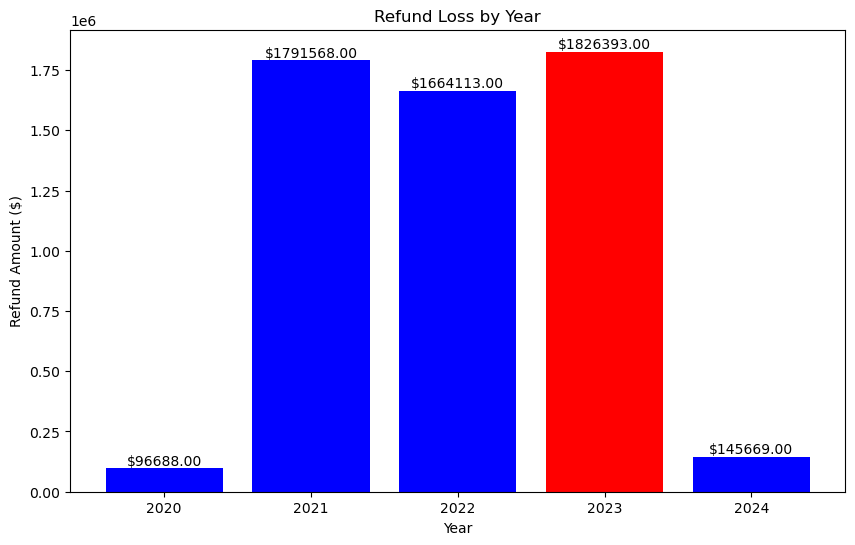

In [101]:
# Step 1: Compute delivery time in minutes
final_data["delivery_time_minutes"] = (final_data["time_stamp"] - final_data["order_placed_at"]).dt.total_seconds() / 60

# Step 2: Filter only late deliveries (more than 30 minutes)
late_deliveries = final_data[final_data["delivery_time_minutes"] > 30]

# Step 3: Expand 'items_ordered' if it's a list
late_deliveries_expanded = late_deliveries.explode("items_ordered").reset_index(drop=True)

# Step 4: Extract year from 'order_placed_at'
late_deliveries_expanded["year"] = late_deliveries_expanded["order_placed_at"].dt.year

# Step 5: Group by year and sum the refund amount
refunds_by_year = late_deliveries_expanded.groupby("year")["Price"].sum()

# Step 6: Identify the year with the maximum refund loss
max_loss_year = refunds_by_year.idxmax()
max_loss_amount = refunds_by_year.max()

# Output the result
print(f"The year with the maximum refund loss is {max_loss_year} with a total loss of ${max_loss_amount:.2f}")

# Step 7: Create a bar chart with different colors
plt.figure(figsize=(10, 6))
bars = plt.bar(refunds_by_year.index, refunds_by_year.values, color=['blue' if year != max_loss_year else 'red' for year in refunds_by_year.index])

# Adding titles and labels
plt.title('Refund Loss by Year')
plt.ylabel('Refund Amount ($)')
plt.xlabel('Year')

# Highlight the year with the maximum refund loss with a label
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 10, f"${yval:.2f}", ha='center', va='bottom')

# Show the plot
plt.show()

# **9.How much revenue is generated by the pizza store till date? Don't include the refund amount in revenue.**

Total Revenue (excluding refunds): $1217979008.00


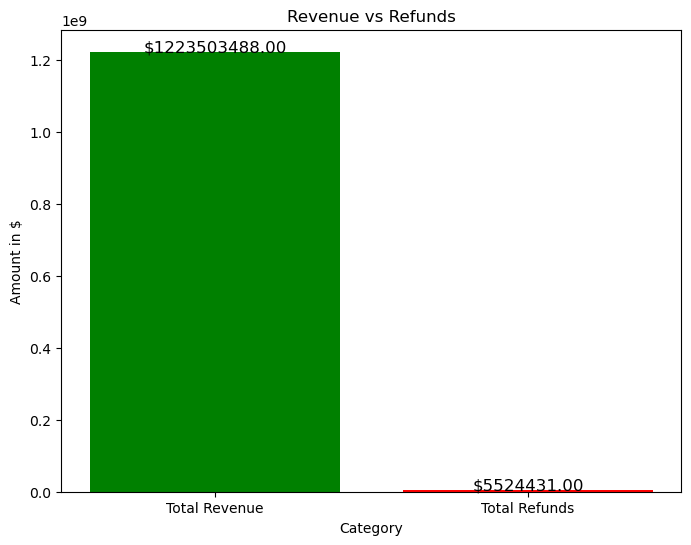

In [100]:
# Step 1: Calculate Total Revenue (sum of all sales)
total_revenue = final_data['Price'].sum()

# Step 2: Filter late deliveries (refunds) - Orders delivered after 30 minutes
late_deliveries = final_data[final_data['delivery_time_minutes'] > 30]

# Step 3: Calculate total refund amount (sum of prices for late deliveries)
total_refunds = late_deliveries['Price'].sum()

# Step 4: Calculate Net Revenue (Total Revenue - Refunds)
net_revenue = total_revenue - total_refunds

# Step 5: Print the result
print(f"Total Revenue (excluding refunds): ${net_revenue:.2f}")

# Step 6: Create a bar chart
labels = ['Total Revenue', 'Total Refunds']
values = [total_revenue, total_refunds]

plt.figure(figsize=(8, 6))
plt.bar(labels, values, color=['green', 'red'])

# Adding titles and labels
plt.title('Revenue vs Refunds')
plt.ylabel('Amount in $')
plt.xlabel('Category')

# Display the amount values on the bars
for i, value in enumerate(values):
    plt.text(i, value + 50, f"${value:.2f}", ha='center', fontsize=12)

# Show the plot
plt.show()